In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/train_data_new.zip')
zip_file.extractall('/content/')

In [ ]:
import torch
import numpy as np
import random

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(33)

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
set_seed(33)
train_transform = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ], p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=7, p=0.5),
        A.MedianBlur(blur_limit=7, p=0.5)
    ], p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

class BalancedDataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.breeds = os.listdir(root_dir)
        self.all_images = []  

    def prepare_all_data(self):
        self.all_images = []  

        for breed in self.breeds:
            happy_dir = os.path.join(self.root_dir, breed, 'happy')
            not_happy_dir = os.path.join(self.root_dir, breed, 'not_happy')

            happy_images = [os.path.join(happy_dir, img) for img in os.listdir(happy_dir)]
            not_happy_images = [os.path.join(not_happy_dir, img) for img in os.listdir(not_happy_dir)]

            self.all_images.extend([(img, 0) for img in happy_images])
            self.all_images.extend([(img, 1) for img in not_happy_images])

        # 이미지 경로와 레이블 분리
        self.img_paths, self.labels = zip(*self.all_images)  

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long) 
            return image, label
        else:
            return image

### dataset, dataloader 구축

In [ ]:
train_dir = '/content/train_data_new'

balanced_dataset = BalancedDataset(train_dir)
balanced_dataset.prepare_all_data()

img_paths = balanced_dataset.img_paths
labels = balanced_dataset.labels
train_img_paths, val_img_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, random_state=33, stratify=labels
)
print(len(img_paths),len(labels))

# train_dataset, val_dataset
train_dataset = CustomDataset(train_img_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_img_paths, val_labels, transform=test_transform)

generator = torch.Generator().manual_seed(33)

# train_loader, val_loader
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, generator=generator
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print("Train Labels Distribution:")
print(train_label_counts)

print("\nValidation Labels Distribution:")
print(val_label_counts)

11028 11028
Train Labels Distribution:
Counter({1: 4934, 0: 3888})

Validation Labels Distribution:
Counter({1: 1234, 0: 972})


### train(), validate() 정의

In [ ]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader,scheduler=None):
    model.train()
    running_loss = 0.0
    corrects = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if scheduler!=None:
          scheduler.step()

        preds = torch.sigmoid(outputs) > 0.5  
        corrects += torch.sum(preds == labels.byte())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5 
            val_corrects += torch.sum(preds == labels.byte())

    epoch_loss = val_loss / len(val_loader)
    epoch_acc = val_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
def save_checkpoint(epoch, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses, 
        'val_losses': val_losses,      
        'train_accuracies': train_accuracies,  
        'val_accuracies': val_accuracies      
    }
    torch.save(checkpoint, save_path)

### resnet18 - AdamW, ReduceLROnPlateau

100%|██████████| 138/138 [00:07<00:00, 18.77it/s]


Epoch 1/50, Train Loss: 0.3777, Train Accuracy: 0.8441, Validation Loss: 0.2081, Validation Accuracy: 0.9189


100%|██████████| 138/138 [00:07<00:00, 18.71it/s]


Epoch 2/50, Train Loss: 0.2826, Train Accuracy: 0.8891, Validation Loss: 0.1938, Validation Accuracy: 0.9275


100%|██████████| 138/138 [00:08<00:00, 16.38it/s]


Epoch 3/50, Train Loss: 0.2724, Train Accuracy: 0.8988, Validation Loss: 0.1901, Validation Accuracy: 0.9320


100%|██████████| 138/138 [00:07<00:00, 17.49it/s]


Epoch 4/50, Train Loss: 0.2460, Train Accuracy: 0.9041, Validation Loss: 0.1797, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:08<00:00, 17.13it/s]


Epoch 5/50, Train Loss: 0.2318, Train Accuracy: 0.9069, Validation Loss: 0.1791, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:08<00:00, 16.69it/s]


Epoch 6/50, Train Loss: 0.2212, Train Accuracy: 0.9160, Validation Loss: 0.1829, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:08<00:00, 17.20it/s]


Epoch 7/50, Train Loss: 0.2068, Train Accuracy: 0.9197, Validation Loss: 0.2013, Validation Accuracy: 0.9311


100%|██████████| 138/138 [00:08<00:00, 16.90it/s]


Epoch 8/50, Train Loss: 0.1896, Train Accuracy: 0.9259, Validation Loss: 0.1842, Validation Accuracy: 0.9334


100%|██████████| 138/138 [00:08<00:00, 17.02it/s]


Epoch 9/50, Train Loss: 0.1682, Train Accuracy: 0.9396, Validation Loss: 0.1734, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:08<00:00, 17.01it/s]


Epoch 10/50, Train Loss: 0.1433, Train Accuracy: 0.9475, Validation Loss: 0.1727, Validation Accuracy: 0.9393


100%|██████████| 138/138 [00:07<00:00, 17.31it/s]


Epoch 11/50, Train Loss: 0.1335, Train Accuracy: 0.9516, Validation Loss: 0.1705, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:07<00:00, 17.73it/s]


Epoch 12/50, Train Loss: 0.1341, Train Accuracy: 0.9492, Validation Loss: 0.1681, Validation Accuracy: 0.9447


100%|██████████| 138/138 [00:07<00:00, 17.84it/s]


Epoch 13/50, Train Loss: 0.1228, Train Accuracy: 0.9555, Validation Loss: 0.1678, Validation Accuracy: 0.9447


100%|██████████| 138/138 [00:07<00:00, 17.79it/s]


Epoch 14/50, Train Loss: 0.1119, Train Accuracy: 0.9613, Validation Loss: 0.1713, Validation Accuracy: 0.9438


100%|██████████| 138/138 [00:07<00:00, 18.34it/s]


Epoch 15/50, Train Loss: 0.1090, Train Accuracy: 0.9590, Validation Loss: 0.1691, Validation Accuracy: 0.9420


100%|██████████| 138/138 [00:07<00:00, 19.05it/s]


Epoch 16/50, Train Loss: 0.1052, Train Accuracy: 0.9630, Validation Loss: 0.1718, Validation Accuracy: 0.9411


100%|██████████| 138/138 [00:07<00:00, 18.94it/s]


Epoch 17/50, Train Loss: 0.0969, Train Accuracy: 0.9670, Validation Loss: 0.1735, Validation Accuracy: 0.9411


100%|██████████| 138/138 [00:07<00:00, 18.76it/s]


Epoch 18/50, Train Loss: 0.1035, Train Accuracy: 0.9635, Validation Loss: 0.1735, Validation Accuracy: 0.9397
Early stopping triggered.


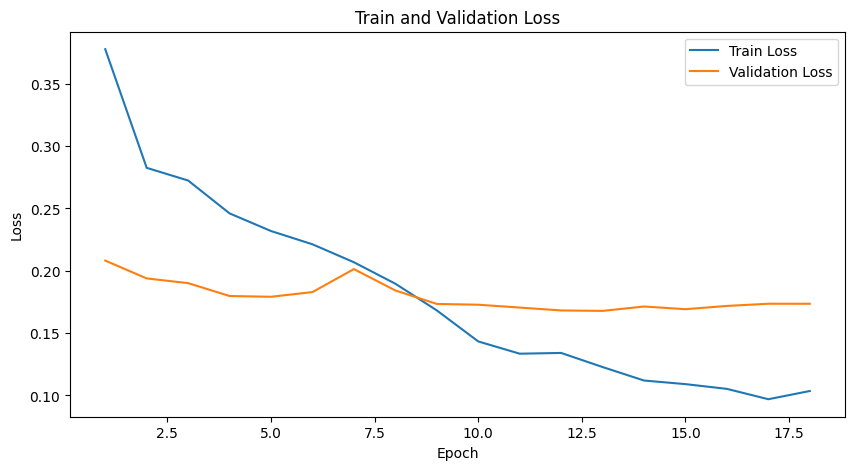

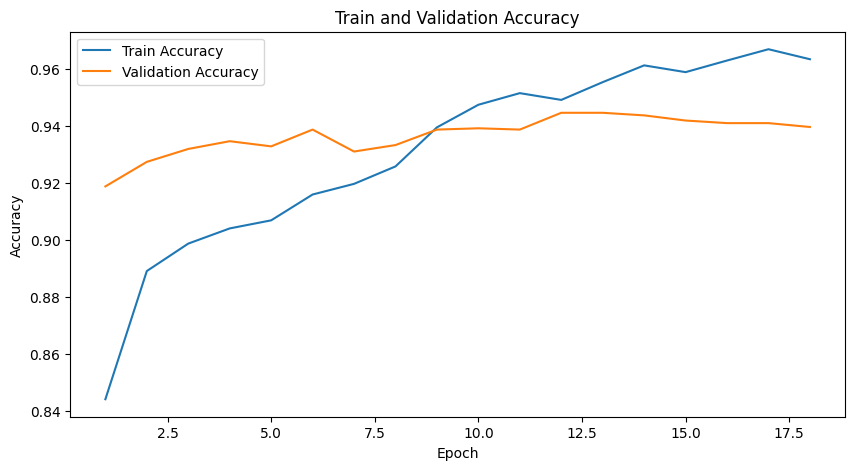

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
from torchvision import models

set_seed(33)
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4  
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf')
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        save_path = f"/content/res18_ada_re_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [12]:
save_path = f"/content/res18_ada_re_b.pth"
save_checkpoint(18, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### resnet18 - sgd, CosineAnnealingWarmRestarts 

100%|██████████| 138/138 [00:07<00:00, 17.89it/s]


Epoch 1/50, Train Loss: 0.4488, Train Accuracy: 0.8240, Validation Loss: 0.2106, Validation Accuracy: 0.9198


100%|██████████| 138/138 [00:07<00:00, 18.35it/s]


Epoch 2/50, Train Loss: 0.3211, Train Accuracy: 0.8781, Validation Loss: 0.1998, Validation Accuracy: 0.9216


100%|██████████| 138/138 [00:07<00:00, 17.45it/s]


Epoch 3/50, Train Loss: 0.2981, Train Accuracy: 0.8862, Validation Loss: 0.2307, Validation Accuracy: 0.9112


100%|██████████| 138/138 [00:07<00:00, 19.67it/s]


Epoch 4/50, Train Loss: 0.2527, Train Accuracy: 0.9035, Validation Loss: 0.1730, Validation Accuracy: 0.9365


100%|██████████| 138/138 [00:07<00:00, 19.26it/s]


Epoch 5/50, Train Loss: 0.2324, Train Accuracy: 0.9114, Validation Loss: 0.2082, Validation Accuracy: 0.9202


100%|██████████| 138/138 [00:07<00:00, 18.11it/s]


Epoch 6/50, Train Loss: 0.2451, Train Accuracy: 0.9055, Validation Loss: 0.1949, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:07<00:00, 18.88it/s]


Epoch 7/50, Train Loss: 0.2200, Train Accuracy: 0.9208, Validation Loss: 0.1930, Validation Accuracy: 0.9343


100%|██████████| 138/138 [00:08<00:00, 15.89it/s]


Epoch 8/50, Train Loss: 0.1690, Train Accuracy: 0.9350, Validation Loss: 0.1789, Validation Accuracy: 0.9361


100%|██████████| 138/138 [00:07<00:00, 17.44it/s]


Epoch 9/50, Train Loss: 0.1545, Train Accuracy: 0.9431, Validation Loss: 0.1685, Validation Accuracy: 0.9415


100%|██████████| 138/138 [00:07<00:00, 17.25it/s]


Epoch 10/50, Train Loss: 0.1885, Train Accuracy: 0.9310, Validation Loss: 0.1849, Validation Accuracy: 0.9275


100%|██████████| 138/138 [00:07<00:00, 17.56it/s]


Epoch 11/50, Train Loss: 0.2085, Train Accuracy: 0.9216, Validation Loss: 0.2303, Validation Accuracy: 0.9080


100%|██████████| 138/138 [00:07<00:00, 17.48it/s]


Epoch 12/50, Train Loss: 0.1908, Train Accuracy: 0.9262, Validation Loss: 0.1879, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:07<00:00, 17.63it/s]


Epoch 13/50, Train Loss: 0.1534, Train Accuracy: 0.9425, Validation Loss: 0.1802, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:07<00:00, 17.35it/s]


Epoch 14/50, Train Loss: 0.1412, Train Accuracy: 0.9467, Validation Loss: 0.2210, Validation Accuracy: 0.9288
Early stopping triggered.


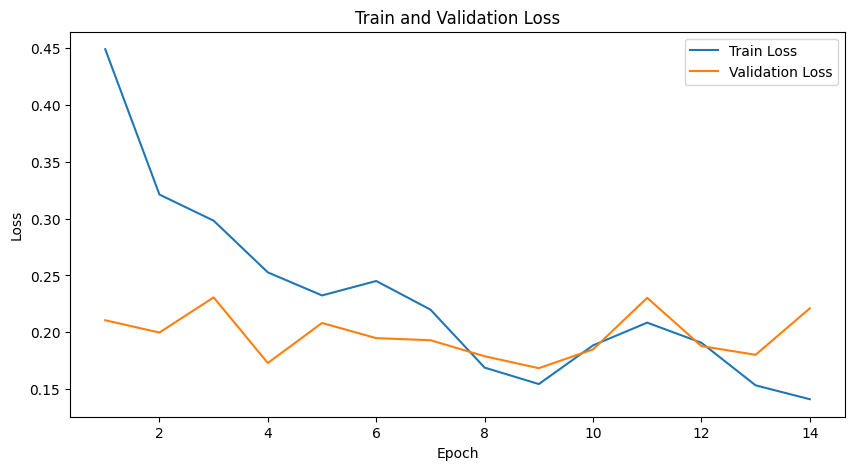

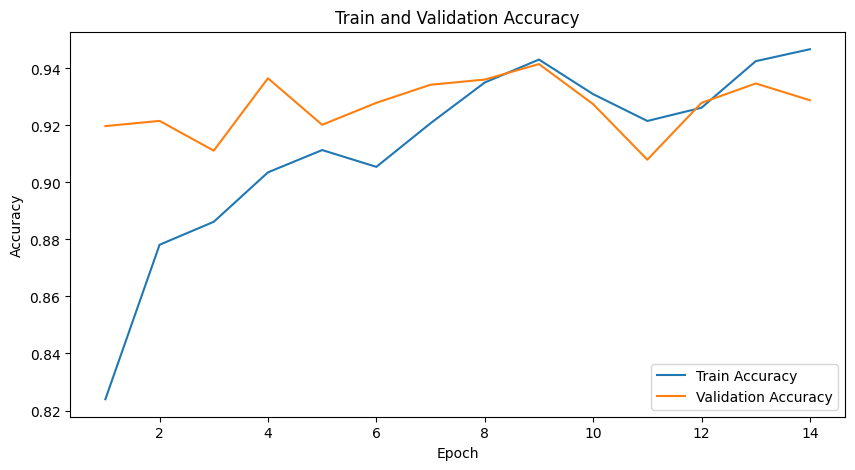

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

set_seed(33)
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader,scheduler)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/res18_sgd_cos_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
save_path = f"/content/res18_sgd_cos_b.pth"
save_checkpoint(14, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### resnet34 - AdamW, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]
100%|██████████| 138/138 [00:08<00:00, 17.22it/s]


Epoch 1/50, Train Loss: 0.3717, Train Accuracy: 0.8444, Validation Loss: 0.2122, Validation Accuracy: 0.9198


100%|██████████| 138/138 [00:08<00:00, 15.79it/s]


Epoch 2/50, Train Loss: 0.2941, Train Accuracy: 0.8826, Validation Loss: 0.2322, Validation Accuracy: 0.9116


100%|██████████| 138/138 [00:08<00:00, 16.68it/s]


Epoch 3/50, Train Loss: 0.2585, Train Accuracy: 0.8965, Validation Loss: 0.2096, Validation Accuracy: 0.9270


100%|██████████| 138/138 [00:08<00:00, 15.69it/s]


Epoch 4/50, Train Loss: 0.2361, Train Accuracy: 0.9081, Validation Loss: 0.1915, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:08<00:00, 16.29it/s]


Epoch 5/50, Train Loss: 0.2294, Train Accuracy: 0.9099, Validation Loss: 0.1917, Validation Accuracy: 0.9316


100%|██████████| 138/138 [00:08<00:00, 15.42it/s]


Epoch 6/50, Train Loss: 0.2101, Train Accuracy: 0.9197, Validation Loss: 0.1803, Validation Accuracy: 0.9302


100%|██████████| 138/138 [00:08<00:00, 15.71it/s]


Epoch 7/50, Train Loss: 0.1990, Train Accuracy: 0.9246, Validation Loss: 0.1918, Validation Accuracy: 0.9275


100%|██████████| 138/138 [00:08<00:00, 15.97it/s]


Epoch 8/50, Train Loss: 0.1851, Train Accuracy: 0.9285, Validation Loss: 0.1722, Validation Accuracy: 0.9343


100%|██████████| 138/138 [00:08<00:00, 15.82it/s]


Epoch 9/50, Train Loss: 0.1723, Train Accuracy: 0.9336, Validation Loss: 0.2267, Validation Accuracy: 0.9170


100%|██████████| 138/138 [00:08<00:00, 15.95it/s]


Epoch 10/50, Train Loss: 0.1674, Train Accuracy: 0.9345, Validation Loss: 0.1892, Validation Accuracy: 0.9379


100%|██████████| 138/138 [00:08<00:00, 15.65it/s]


Epoch 11/50, Train Loss: 0.1587, Train Accuracy: 0.9396, Validation Loss: 0.1935, Validation Accuracy: 0.9293


100%|██████████| 138/138 [00:08<00:00, 15.94it/s]


Epoch 12/50, Train Loss: 0.1171, Train Accuracy: 0.9574, Validation Loss: 0.1794, Validation Accuracy: 0.9356


100%|██████████| 138/138 [00:08<00:00, 15.66it/s]


Epoch 13/50, Train Loss: 0.1167, Train Accuracy: 0.9572, Validation Loss: 0.1878, Validation Accuracy: 0.9329
Early stopping triggered.


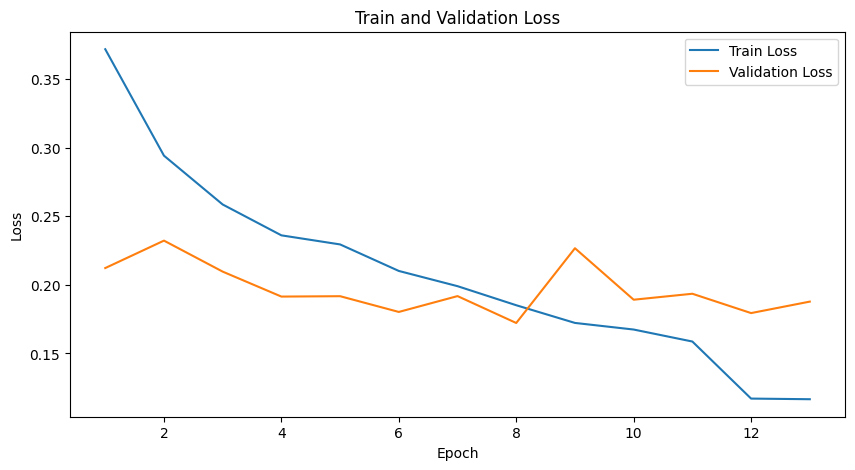

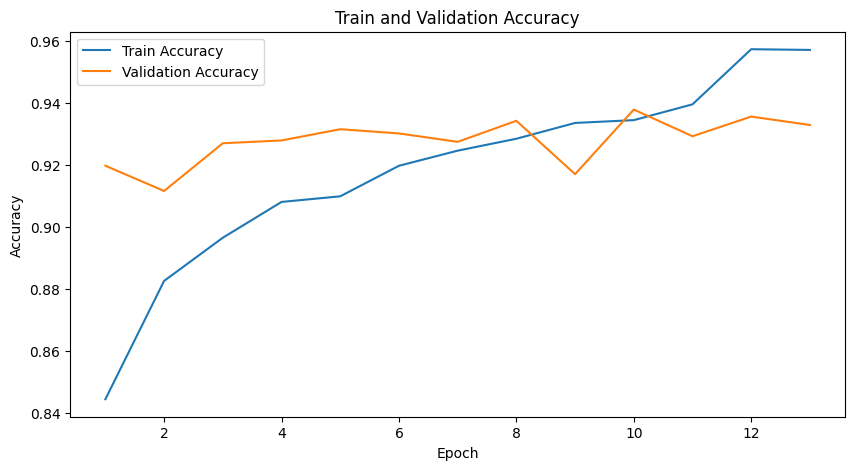

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

set_seed(33)
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        save_path = f"/content/res34_ada_re_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [16]:
save_path = f"/content/res34_ada_re_b.pth"
save_checkpoint(13, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### resnet34 - sgd, CosineAnnealingWarmRestarts

100%|██████████| 138/138 [00:08<00:00, 16.14it/s]


Epoch 1/50, Train Loss: 0.4721, Train Accuracy: 0.8236, Validation Loss: 0.2130, Validation Accuracy: 0.9189


100%|██████████| 138/138 [00:08<00:00, 17.22it/s]


Epoch 2/50, Train Loss: 0.3102, Train Accuracy: 0.8784, Validation Loss: 0.1944, Validation Accuracy: 0.9234


100%|██████████| 138/138 [00:08<00:00, 15.82it/s]


Epoch 3/50, Train Loss: 0.2981, Train Accuracy: 0.8801, Validation Loss: 0.2184, Validation Accuracy: 0.9189


100%|██████████| 138/138 [00:08<00:00, 17.21it/s]


Epoch 4/50, Train Loss: 0.2429, Train Accuracy: 0.9085, Validation Loss: 0.1904, Validation Accuracy: 0.9275


100%|██████████| 138/138 [00:08<00:00, 15.98it/s]


Epoch 5/50, Train Loss: 0.2359, Train Accuracy: 0.9092, Validation Loss: 0.2294, Validation Accuracy: 0.9284


100%|██████████| 138/138 [00:08<00:00, 17.04it/s]


Epoch 6/50, Train Loss: 0.2564, Train Accuracy: 0.9039, Validation Loss: 0.1936, Validation Accuracy: 0.9361


100%|██████████| 138/138 [00:08<00:00, 15.87it/s]


Epoch 7/50, Train Loss: 0.2095, Train Accuracy: 0.9188, Validation Loss: 0.1774, Validation Accuracy: 0.9334


100%|██████████| 138/138 [00:08<00:00, 15.89it/s]


Epoch 8/50, Train Loss: 0.1827, Train Accuracy: 0.9292, Validation Loss: 0.1702, Validation Accuracy: 0.9365


100%|██████████| 138/138 [00:08<00:00, 16.81it/s]


Epoch 9/50, Train Loss: 0.1598, Train Accuracy: 0.9373, Validation Loss: 0.1672, Validation Accuracy: 0.9393


100%|██████████| 138/138 [00:08<00:00, 15.86it/s]


Epoch 10/50, Train Loss: 0.1823, Train Accuracy: 0.9297, Validation Loss: 0.2174, Validation Accuracy: 0.9279


100%|██████████| 138/138 [00:07<00:00, 17.25it/s]


Epoch 11/50, Train Loss: 0.1945, Train Accuracy: 0.9256, Validation Loss: 0.2159, Validation Accuracy: 0.9266


100%|██████████| 138/138 [00:08<00:00, 16.01it/s]


Epoch 12/50, Train Loss: 0.1850, Train Accuracy: 0.9328, Validation Loss: 0.1828, Validation Accuracy: 0.9320


100%|██████████| 138/138 [00:08<00:00, 16.69it/s]


Epoch 13/50, Train Loss: 0.1632, Train Accuracy: 0.9353, Validation Loss: 0.1919, Validation Accuracy: 0.9356


100%|██████████| 138/138 [00:08<00:00, 15.71it/s]


Epoch 14/50, Train Loss: 0.1467, Train Accuracy: 0.9459, Validation Loss: 0.1932, Validation Accuracy: 0.9302
Early stopping triggered.


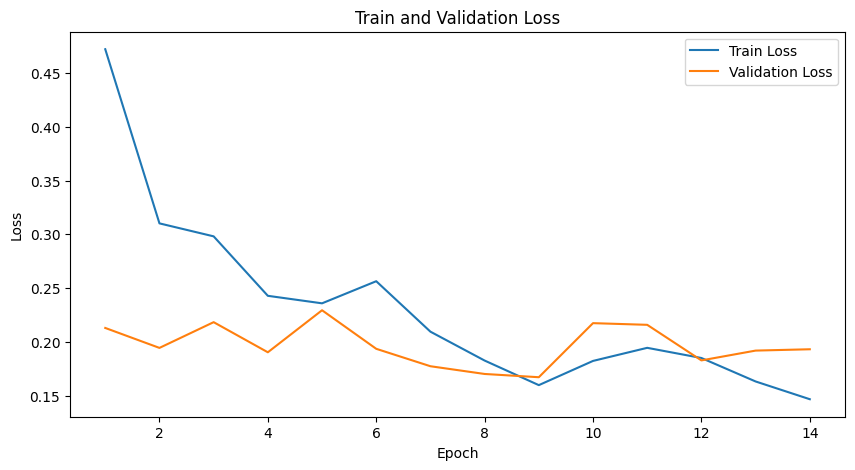

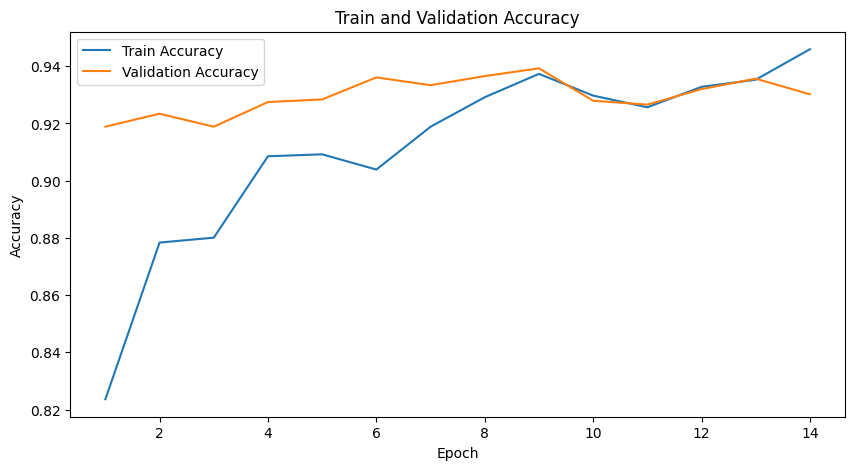

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

set_seed(33)
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader,scheduler)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        save_path = f"/content/res34_sgd_cos_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
save_path = f"/content/res34_sgd_cos_b.pth"
save_checkpoint(14, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### resnet34- sgd

100%|██████████| 138/138 [00:08<00:00, 16.30it/s]


Epoch 1/50, Train Loss: 0.4628, Train Accuracy: 0.8165, Validation Loss: 0.2733, Validation Accuracy: 0.8921


100%|██████████| 138/138 [00:08<00:00, 16.11it/s]


Epoch 2/50, Train Loss: 0.3173, Train Accuracy: 0.8795, Validation Loss: 0.2133, Validation Accuracy: 0.9161


100%|██████████| 138/138 [00:08<00:00, 15.90it/s]


Epoch 3/50, Train Loss: 0.2871, Train Accuracy: 0.8922, Validation Loss: 0.1965, Validation Accuracy: 0.9243


100%|██████████| 138/138 [00:08<00:00, 16.76it/s]


Epoch 4/50, Train Loss: 0.2484, Train Accuracy: 0.9057, Validation Loss: 0.1954, Validation Accuracy: 0.9338


100%|██████████| 138/138 [00:08<00:00, 15.84it/s]


Epoch 5/50, Train Loss: 0.2323, Train Accuracy: 0.9114, Validation Loss: 0.1991, Validation Accuracy: 0.9325


100%|██████████| 138/138 [00:07<00:00, 17.39it/s]


Epoch 6/50, Train Loss: 0.2181, Train Accuracy: 0.9165, Validation Loss: 0.1974, Validation Accuracy: 0.9316


100%|██████████| 138/138 [00:08<00:00, 15.81it/s]


Epoch 7/50, Train Loss: 0.2014, Train Accuracy: 0.9234, Validation Loss: 0.1947, Validation Accuracy: 0.9356


100%|██████████| 138/138 [00:08<00:00, 17.12it/s]


Epoch 8/50, Train Loss: 0.1841, Train Accuracy: 0.9256, Validation Loss: 0.1718, Validation Accuracy: 0.9397


100%|██████████| 138/138 [00:08<00:00, 16.14it/s]


Epoch 9/50, Train Loss: 0.1820, Train Accuracy: 0.9318, Validation Loss: 0.1944, Validation Accuracy: 0.9352


100%|██████████| 138/138 [00:08<00:00, 16.05it/s]


Epoch 10/50, Train Loss: 0.1743, Train Accuracy: 0.9349, Validation Loss: 0.1867, Validation Accuracy: 0.9397


100%|██████████| 138/138 [00:08<00:00, 16.45it/s]


Epoch 11/50, Train Loss: 0.1561, Train Accuracy: 0.9408, Validation Loss: 0.1910, Validation Accuracy: 0.9338


100%|██████████| 138/138 [00:08<00:00, 15.63it/s]


Epoch 12/50, Train Loss: 0.1495, Train Accuracy: 0.9412, Validation Loss: 0.1833, Validation Accuracy: 0.9415


100%|██████████| 138/138 [00:08<00:00, 16.82it/s]


Epoch 13/50, Train Loss: 0.1431, Train Accuracy: 0.9458, Validation Loss: 0.1968, Validation Accuracy: 0.9334
Early stopping triggered.


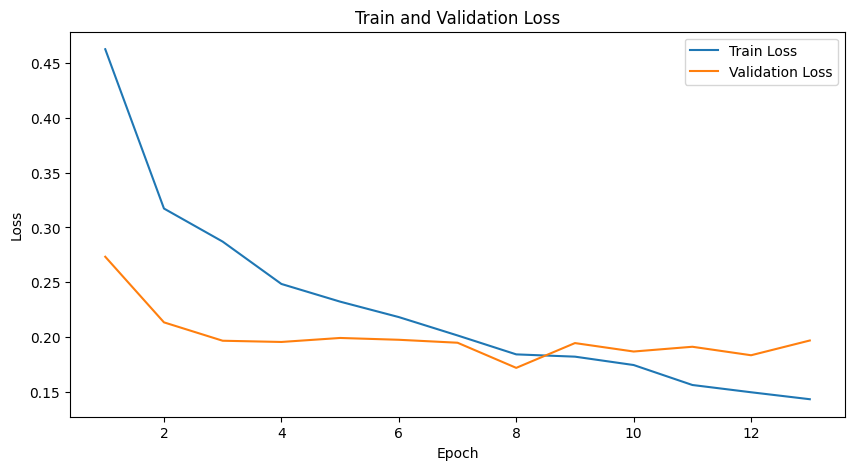

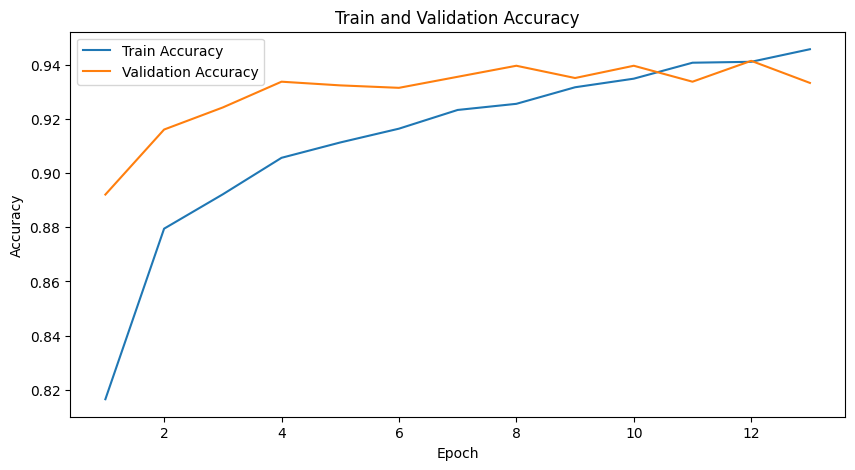

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

set_seed(33)
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf')
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/res34_sgd_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [20]:
save_path = f"/content/res34_sgd_b.pth"
save_checkpoint(13, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### resnet34- sgd, StepLR

100%|██████████| 138/138 [00:08<00:00, 17.08it/s]


Epoch 1/50, Train Loss: 0.4781, Train Accuracy: 0.8159, Validation Loss: 0.2781, Validation Accuracy: 0.8989


100%|██████████| 138/138 [00:08<00:00, 16.08it/s]


Epoch 2/50, Train Loss: 0.3010, Train Accuracy: 0.8870, Validation Loss: 0.2729, Validation Accuracy: 0.8930


100%|██████████| 138/138 [00:08<00:00, 16.24it/s]


Epoch 3/50, Train Loss: 0.2928, Train Accuracy: 0.8857, Validation Loss: 0.1903, Validation Accuracy: 0.9229


100%|██████████| 138/138 [00:08<00:00, 16.65it/s]


Epoch 4/50, Train Loss: 0.2663, Train Accuracy: 0.8970, Validation Loss: 0.2109, Validation Accuracy: 0.9152


100%|██████████| 138/138 [00:08<00:00, 15.97it/s]


Epoch 5/50, Train Loss: 0.2378, Train Accuracy: 0.9084, Validation Loss: 0.1885, Validation Accuracy: 0.9252


100%|██████████| 138/138 [00:08<00:00, 17.23it/s]


Epoch 6/50, Train Loss: 0.1762, Train Accuracy: 0.9326, Validation Loss: 0.1716, Validation Accuracy: 0.9383


100%|██████████| 138/138 [00:08<00:00, 16.25it/s]


Epoch 7/50, Train Loss: 0.1706, Train Accuracy: 0.9332, Validation Loss: 0.1697, Validation Accuracy: 0.9365


100%|██████████| 138/138 [00:08<00:00, 17.02it/s]


Epoch 8/50, Train Loss: 0.1696, Train Accuracy: 0.9335, Validation Loss: 0.1683, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:08<00:00, 16.39it/s]


Epoch 9/50, Train Loss: 0.1551, Train Accuracy: 0.9430, Validation Loss: 0.1671, Validation Accuracy: 0.9361


100%|██████████| 138/138 [00:08<00:00, 15.80it/s]


Epoch 10/50, Train Loss: 0.1525, Train Accuracy: 0.9425, Validation Loss: 0.1690, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:08<00:00, 17.12it/s]


Epoch 11/50, Train Loss: 0.1418, Train Accuracy: 0.9460, Validation Loss: 0.1677, Validation Accuracy: 0.9383


100%|██████████| 138/138 [00:08<00:00, 16.19it/s]


Epoch 12/50, Train Loss: 0.1525, Train Accuracy: 0.9415, Validation Loss: 0.1681, Validation Accuracy: 0.9379


100%|██████████| 138/138 [00:08<00:00, 17.25it/s]


Epoch 13/50, Train Loss: 0.1400, Train Accuracy: 0.9460, Validation Loss: 0.1689, Validation Accuracy: 0.9388


100%|██████████| 138/138 [00:08<00:00, 15.96it/s]


Epoch 14/50, Train Loss: 0.1464, Train Accuracy: 0.9443, Validation Loss: 0.1721, Validation Accuracy: 0.9402
Early stopping triggered.


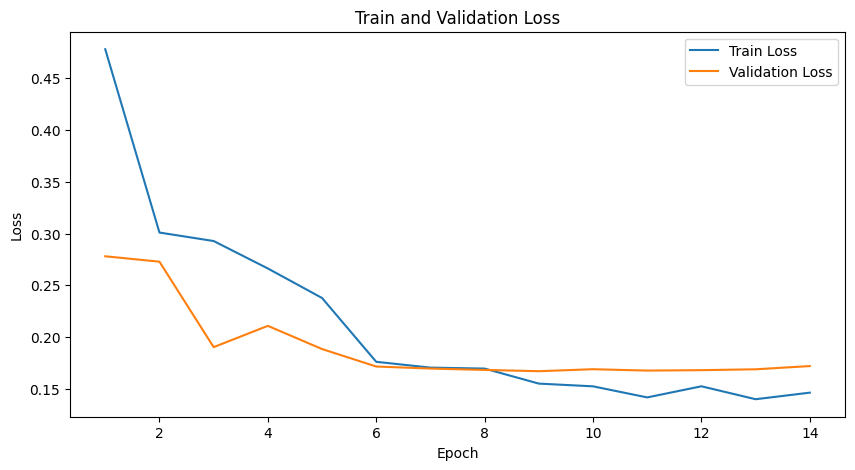

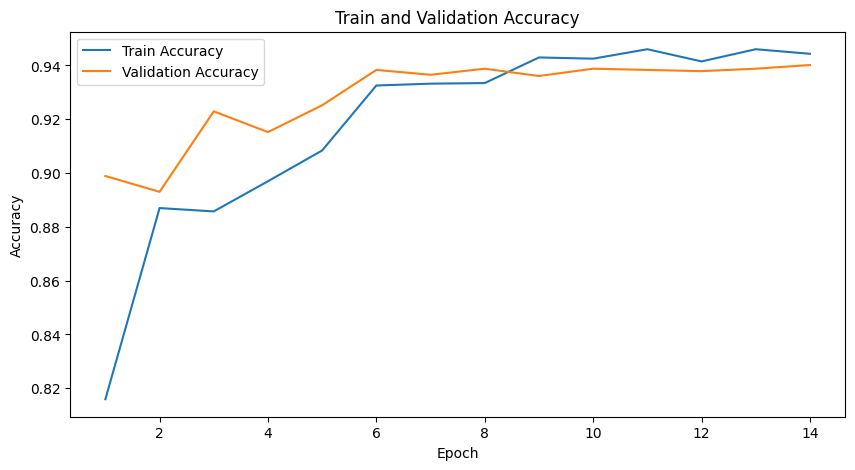

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

set_seed(33)
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = 1
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf')
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")
    scheduler.step()
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        save_path = f"/content/res34_sgd_st_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
save_path = f"/content/res34_sgd_st_b.pth"
save_checkpoint(14, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)